# NYC Taxi Fare Prediction

## Setup

In [451]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.cluster import OPTICS
from sklearn.preprocessing import StandardScaler

from geopy import distance
from string import ascii_uppercase

## Inspection

In [452]:
taxi = pd.read_csv('train_prev.csv')        # Truncated preview
taxi.head(5)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [453]:
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,11.354652,-72.494682,39.914481,-72.490967,39.919053,1.673820
std,9.716777,10.693934,6.225686,10.471386,6.213427,1.300171
min,-44.900000,-736.550000,-74.007670,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992041,40.734996,-73.991215,40.734182,1.000000
50%,8.500000,-73.981789,40.752765,-73.980000,40.753243,1.000000
75%,12.500000,-73.966982,40.767258,-73.963433,40.768166,2.000000
max,200.000000,40.787575,401.083332,40.851027,404.616667,6.000000


In [454]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                100000 non-null  object 
 1   fare_amount        100000 non-null  float64
 2   pickup_datetime    100000 non-null  object 
 3   pickup_longitude   100000 non-null  float64
 4   pickup_latitude    100000 non-null  float64
 5   dropoff_longitude  100000 non-null  float64
 6   dropoff_latitude   100000 non-null  float64
 7   passenger_count    100000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 6.1+ MB


## Cleaning

### Pickup Datetime

In [455]:
taxi['pickup_datetime'] = pd.to_datetime(taxi['pickup_datetime'], infer_datetime_format=True)
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                100000 non-null  object             
 1   fare_amount        100000 non-null  float64            
 2   pickup_datetime    100000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   100000 non-null  float64            
 4   pickup_latitude    100000 non-null  float64            
 5   dropoff_longitude  100000 non-null  float64            
 6   dropoff_latitude   100000 non-null  float64            
 7   passenger_count    100000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 6.1+ MB


### NaN Values

In [456]:
taxi.dropna(subset=['dropoff_longitude', 'dropoff_latitude'], inplace=True)
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                100000 non-null  object             
 1   fare_amount        100000 non-null  float64            
 2   pickup_datetime    100000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   100000 non-null  float64            
 4   pickup_latitude    100000 non-null  float64            
 5   dropoff_longitude  100000 non-null  float64            
 6   dropoff_latitude   100000 non-null  float64            
 7   passenger_count    100000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 6.1+ MB


### Fare Amount

<Axes: xlabel='fare_amount'>

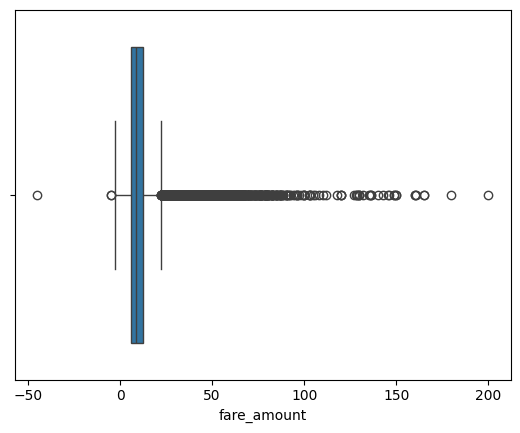

In [457]:
sns.boxplot(data=taxi, x='fare_amount')

In [458]:
# len(taxi.loc[~taxi['fare_amount'].between(0, 200)])
taxi = taxi.loc[taxi['fare_amount'].between(0, 200)]
taxi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99991 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                99991 non-null  object             
 1   fare_amount        99991 non-null  float64            
 2   pickup_datetime    99991 non-null  datetime64[ns, UTC]
 3   pickup_longitude   99991 non-null  float64            
 4   pickup_latitude    99991 non-null  float64            
 5   dropoff_longitude  99991 non-null  float64            
 6   dropoff_latitude   99991 non-null  float64            
 7   passenger_count    99991 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 6.9+ MB


### Pickup Longitude

<Axes: xlabel='pickup_longitude'>

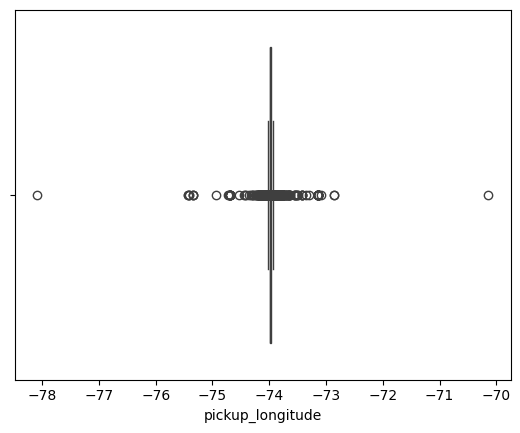

In [459]:
sns.boxplot(data=taxi.loc[taxi['pickup_longitude'].between(-80, -70)], x='pickup_longitude')

In [460]:
# len(taxi.loc[~taxi['pickup_longitude'].between(-75, -73)])
taxi = taxi.loc[taxi['pickup_longitude'].between(-75, -73)]
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97994.000000,97994.000000,97994.000000,97994.000000,97994.000000,97994.000000
mean,11.344980,-73.975106,40.754226,-73.910252,40.724806,1.674296
std,9.690929,0.039925,1.168172,2.168744,1.609409,1.300335
min,0.000000,-74.945938,0.783332,-84.654241,-2.269701,0.000000
25%,6.000000,-73.992265,40.736638,-73.991390,40.735677,1.000000
50%,8.500000,-73.982073,40.753532,-73.980422,40.753937,1.000000
75%,12.500000,-73.968288,40.767673,-73.965046,40.768474,2.000000
max,200.000000,-73.085745,401.083332,0.000000,404.616667,6.000000


### Pickup Latitude

<Axes: xlabel='pickup_latitude'>

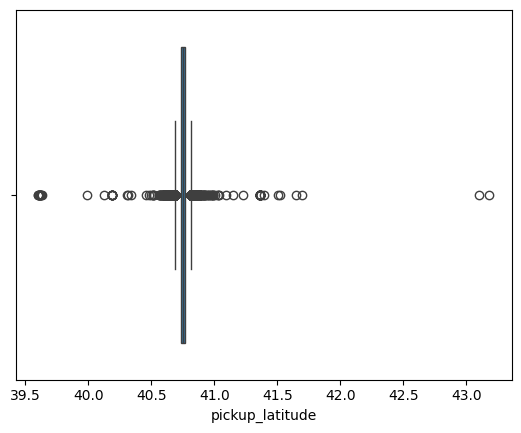

In [461]:
sns.boxplot(data=taxi.loc[taxi['pickup_latitude'].between(30, 50)], x='pickup_latitude')

In [462]:
# len(taxi.loc[~taxi['pickup_latitude'].between(40, 41)])
taxi = taxi.loc[taxi['pickup_latitude'].between(40, 41)]
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97926.000000,97926.000000,97926.000000,97926.000000,97926.000000,97926.000000
mean,11.338024,-73.975425,40.750858,-73.910417,40.724619,1.674509
std,9.638646,0.036281,0.027773,2.169460,1.609887,1.300519
min,0.000000,-74.718822,40.121653,-84.654241,-2.269701,0.000000
25%,6.000000,-73.992270,40.736635,-73.991392,40.735670,1.000000
50%,8.500000,-73.982080,40.753517,-73.980429,40.753927,1.000000
75%,12.500000,-73.968323,40.767648,-73.965087,40.768452,2.000000
max,180.000000,-73.085745,40.993260,0.000000,404.616667,6.000000


### Dropoff Longitude

<Axes: xlabel='dropoff_longitude'>

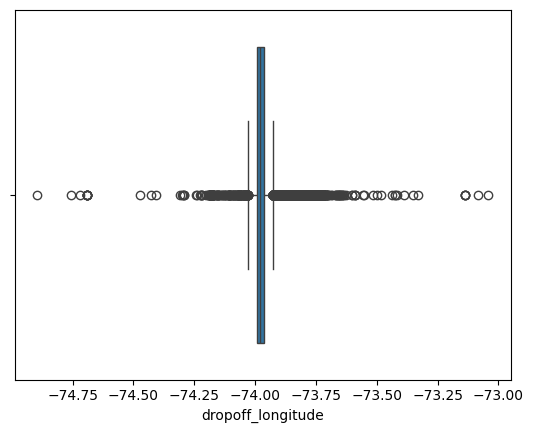

In [463]:
sns.boxplot(data=taxi.loc[taxi['dropoff_longitude'].between(-80, -70)], x='dropoff_longitude')

In [464]:
# len(taxi.loc[~taxi['dropoff_longitude'].between(-75, -73)])
taxi = taxi.loc[taxi['dropoff_longitude'].between(-75, -73)]
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97840.000000,97840.000000,97840.000000,97840.000000,97840.000000,97840.000000
mean,11.336845,-73.975431,40.750864,-73.974221,40.754608,1.674458
std,9.633250,0.036265,0.027767,0.036690,1.170761,1.300347
min,0.000000,-74.718822,40.121653,-74.895028,0.728087,0.000000
25%,6.000000,-73.992271,40.736635,-73.991402,40.735735,1.000000
50%,8.500000,-73.982084,40.753519,-73.980442,40.753951,1.000000
75%,12.500000,-73.968323,40.767650,-73.965153,40.768470,2.000000
max,180.000000,-73.085745,40.993260,-73.041317,404.616667,6.000000


### Dropoff Latitude

<Axes: xlabel='dropoff_latitude'>

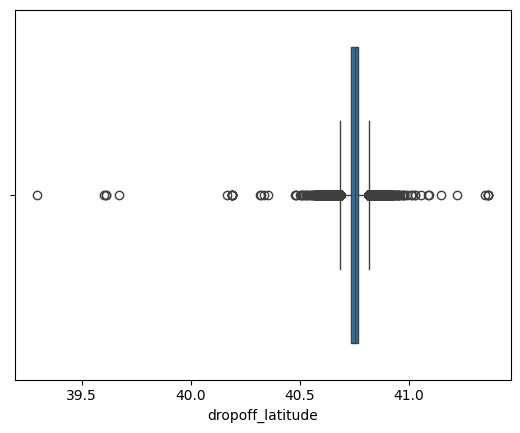

In [465]:
sns.boxplot(data=taxi.loc[taxi['dropoff_latitude'].between(30, 50)], x='dropoff_latitude')

In [466]:
# len(taxi.loc[~taxi['dropoff_latitude'].between(40, 41)])
taxi = taxi.loc[taxi['dropoff_latitude'].between(40, 41)]
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97819.000000,97819.000000,97819.000000,97819.000000,97819.000000,97819.000000
mean,11.330071,-73.975434,40.750859,-73.974263,40.751298,1.674521
std,9.594498,0.036211,0.027744,0.036014,0.031538,1.300405
min,0.000000,-74.718822,40.121653,-74.755480,40.164927,0.000000
25%,6.000000,-73.992272,40.736639,-73.991402,40.735737,1.000000
50%,8.500000,-73.982084,40.753515,-73.980443,40.753948,1.000000
75%,12.500000,-73.968328,40.767648,-73.965161,40.768459,2.000000
max,180.000000,-73.085745,40.993260,-73.085764,40.992487,6.000000


### Passenger Count

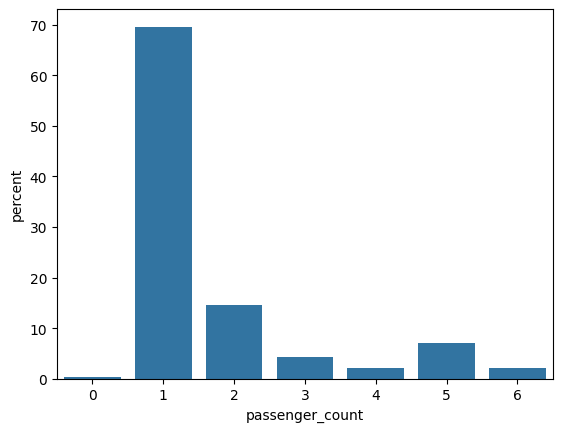

In [467]:
passenger_plt = sns.countplot(data=taxi, x='passenger_count', stat='percent')

In [468]:
# len(taxi.loc[taxi['passenger_count'] == 0])
taxi = taxi.loc[taxi['passenger_count'] != 0]
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97461.000000,97461.000000,97461.000000,97461.000000,97461.000000,97461.000000
mean,11.338010,-73.975426,40.750856,-73.974266,40.751298,1.680672
std,9.604238,0.036230,0.027745,0.036013,0.031526,1.298817
min,0.000000,-74.718822,40.121653,-74.755480,40.164927,1.000000
25%,6.000000,-73.992270,40.736643,-73.991400,40.735750,1.000000
50%,8.500000,-73.982082,40.753512,-73.980444,40.753948,1.000000
75%,12.500000,-73.968323,40.767648,-73.965168,40.768450,2.000000
max,180.000000,-73.085745,40.993260,-73.085764,40.992487,6.000000


###

In [469]:
taxi.reset_index(drop=True, inplace=True)

In [470]:
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97461.000000,97461.000000,97461.000000,97461.000000,97461.000000,97461.000000
mean,11.338010,-73.975426,40.750856,-73.974266,40.751298,1.680672
std,9.604238,0.036230,0.027745,0.036013,0.031526,1.298817
min,0.000000,-74.718822,40.121653,-74.755480,40.164927,1.000000
25%,6.000000,-73.992270,40.736643,-73.991400,40.735750,1.000000
50%,8.500000,-73.982082,40.753512,-73.980444,40.753948,1.000000
75%,12.500000,-73.968323,40.767648,-73.965168,40.768450,2.000000
max,180.000000,-73.085745,40.993260,-73.085764,40.992487,6.000000


In [471]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97461 entries, 0 to 97460
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                97461 non-null  object             
 1   fare_amount        97461 non-null  float64            
 2   pickup_datetime    97461 non-null  datetime64[ns, UTC]
 3   pickup_longitude   97461 non-null  float64            
 4   pickup_latitude    97461 non-null  float64            
 5   dropoff_longitude  97461 non-null  float64            
 6   dropoff_latitude   97461 non-null  float64            
 7   passenger_count    97461 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 5.9+ MB


## Feature Engineering

### Distance

In [472]:
taxi['distance_km'] = taxi.apply(lambda r:distance.distance((r['pickup_latitude'], r['pickup_longitude']),(r['dropoff_latitude'], r['dropoff_longitude'])).km, axis=1)

taxi.head(5)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,1.029601
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,8.443441
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389132
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2.795790
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.998338


In [473]:
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km
count,97461.000000,97461.000000,97461.000000,97461.000000,97461.000000,97461.000000,97461.000000
mean,11.338010,-73.975426,40.750856,-73.974266,40.751298,1.680672,3.324094
std,9.604238,0.036230,0.027745,0.036013,0.031526,1.298817,3.598433
min,0.000000,-74.718822,40.121653,-74.755480,40.164927,1.000000,0.000000
25%,6.000000,-73.992270,40.736643,-73.991400,40.735750,1.000000,1.255759
50%,8.500000,-73.982082,40.753512,-73.980444,40.753948,1.000000,2.158052
75%,12.500000,-73.968323,40.767648,-73.965168,40.768450,2.000000,3.923854
max,180.000000,-73.085745,40.993260,-73.085764,40.992487,6.000000,85.840891


### Time

In [474]:
taxi['pickup_hr'] = taxi.apply(lambda r: r['pickup_datetime'].hour, axis=1)
taxi['pickup_dayofweek'] = taxi.apply(lambda r: r['pickup_datetime'].dayofweek, axis=1)
taxi['pickup_dayofweek'].replace({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun', }, inplace=True)
taxi['pickup_month'] = taxi.apply(lambda r: r['pickup_datetime'].month, axis=1)
taxi['pickup_year'] = taxi.apply(lambda r: r['pickup_datetime'].year, axis=1)

taxi['pickup_nighttime'] = taxi.apply(lambda r: r['pickup_hr'] in [20, 21, 22, 23, 0, 1, 2, 3, 4, 5], axis=1)

In [475]:
taxi.tail(20)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,pickup_hr,pickup_dayofweek,pickup_month,pickup_year,pickup_nighttime
97441,2011-03-21 15:05:00.000000136,14.1,2011-03-21 15:05:00+00:00,-73.984670,40.761037,-74.016033,40.714663,2,5.791223,15,Mon,3,2011,False
97442,2011-07-30 18:10:00.000000139,16.9,2011-07-30 18:10:00+00:00,-73.955607,40.782738,-74.009868,40.746623,2,6.088862,18,Sat,7,2011,False
97443,2009-05-19 22:47:00.00000099,4.5,2009-05-19 22:47:00+00:00,-73.968073,40.761478,-73.973773,40.756237,2,0.755247,22,Tue,5,2009,True
97444,2010-06-03 08:27:00.000000184,8.9,2010-06-03 08:27:00+00:00,-73.982137,40.775522,-73.972260,40.759723,1,1.942570,8,Thu,6,2010,False
97445,2013-05-31 23:05:48.0000001,13.0,2013-05-31 23:05:48+00:00,-73.988230,40.779344,-73.984451,40.745273,1,3.796992,23,Fri,5,2013,True
97446,2009-06-27 00:47:00.00000058,4.9,2009-06-27 00:47:00+00:00,-73.980930,40.729518,-73.986248,40.738617,1,1.105792,0,Sat,6,2009,True
97447,2014-08-23 10:09:52.0000003,118.0,2014-08-23 10:09:52+00:00,-74.114228,40.815658,-74.114228,40.815657,1,0.000111,10,Sat,8,2014,False
97448,2015-06-19 11:29:31.0000004,6.0,2015-06-19 11:29:31+00:00,-73.946312,40.777363,-73.955620,40.764187,1,1.660852,11,Fri,6,2015,False
97449,2011-03-05 10:01:58.0000004,11.7,2011-03-05 10:01:58+00:00,-73.990850,40.751173,-73.955861,40.776090,3,4.047747,10,Sat,3,2011,False
97450,2012-01-30 01:40:00.0000008,5.3,2012-01-30 01:40:00+00:00,-73.992065,40.759142,-73.979150,40.762897,1,1.167526,1,Mon,1,2012,True


### Passengers

In [476]:
taxi['multiple_passengers'] = np.where(taxi['passenger_count'] > 1, True, False)

### Location

In [477]:
clust_name_dict = {i:f'cluster_{c}' for i,c in enumerate(ascii_uppercase)}

pickup_locs = taxi[['pickup_longitude', 'pickup_latitude']]

kmeans = KMeans(n_clusters=8, n_init=10)
kmeans.fit(pickup_locs)

taxi['pickup_loc'] = pd.Series(kmeans.labels_).replace(clust_name_dict)

In [478]:
dropoff_locs = taxi[['dropoff_longitude', 'dropoff_latitude']]

kmeans = KMeans(n_clusters=8, n_init=10)
kmeans.fit(dropoff_locs)

taxi['dropoff_loc'] = pd.Series(kmeans.labels_).replace(clust_name_dict)

In [479]:
distance_locs = taxi[['distance_km', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]

kmeans = KMeans(n_clusters=8, n_init=10)
kmeans.fit(distance_locs)

taxi['distance_loc'] = pd.Series(kmeans.labels_).replace(clust_name_dict)

## Relationships

### Fare vs Distance

<Axes: xlabel='distance_km', ylabel='fare_amount'>

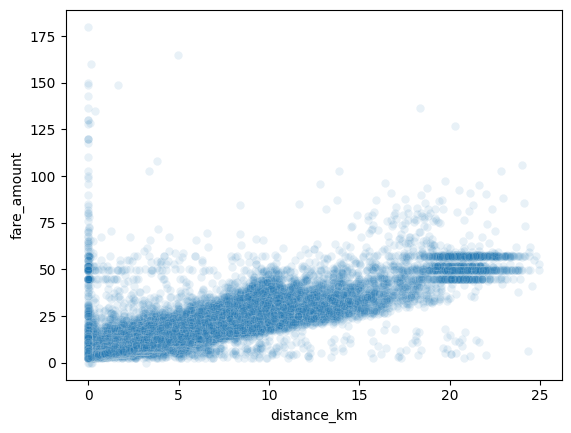

In [480]:
sns.scatterplot(data=taxi.loc[taxi['distance_km'] <= 25], x='distance_km', y='fare_amount', alpha=0.1)

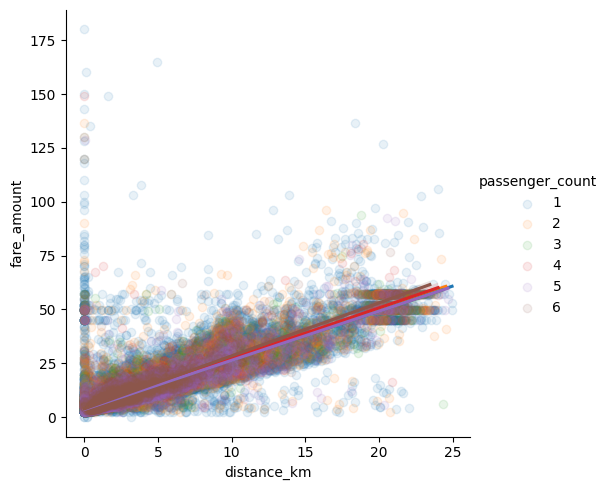

In [481]:
sns.lmplot(data=taxi.loc[taxi['distance_km'] <= 25], x='distance_km', y='fare_amount', hue='passenger_count', scatter_kws={'alpha':0.1})

### Fare vs Passengers

<Axes: xlabel='passenger_count', ylabel='count'>

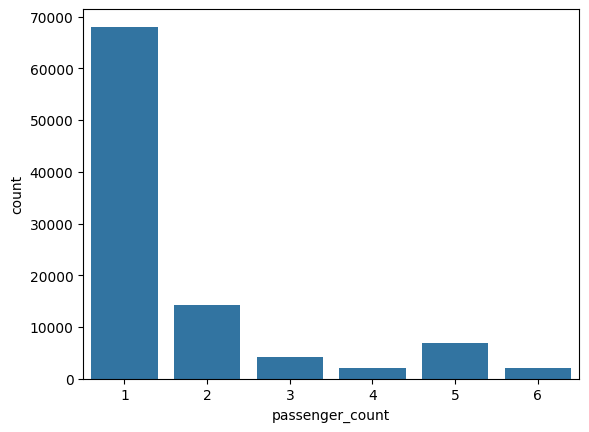

In [482]:
sns.countplot(data=taxi, x='passenger_count')

<Axes: xlabel='passenger_count', ylabel='fare_amount'>

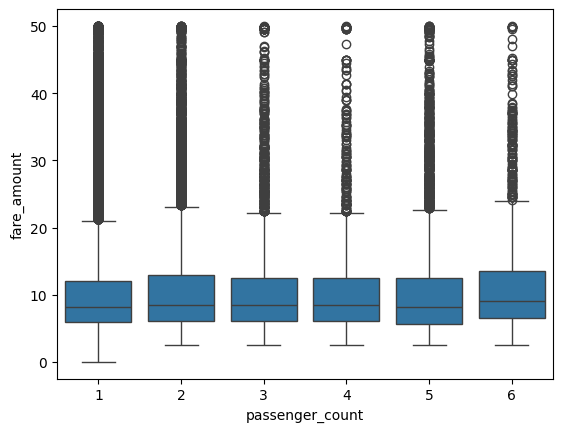

In [483]:
sns.boxplot(data=taxi.loc[taxi['fare_amount'] <= 50], x='passenger_count', y='fare_amount')

<Axes: xlabel='multiple_passengers', ylabel='fare_amount'>

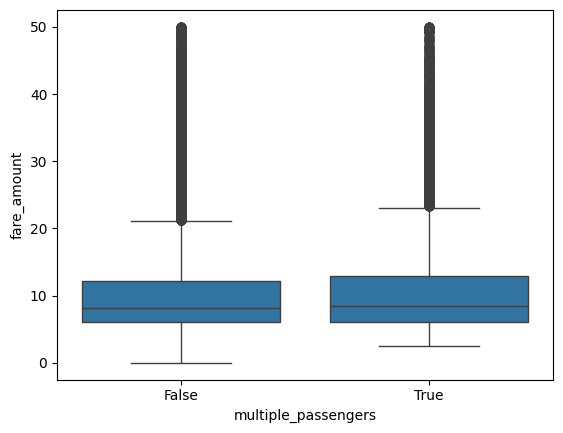

In [484]:
taxi_pass_red = taxi.copy()
taxi_pass_red['multiple_passengers'] = np.where(taxi_pass_red['passenger_count'] > 1, True, False)

sns.boxplot(data=taxi_pass_red.loc[taxi_pass_red['fare_amount'] <= 50], x='multiple_passengers', y='fare_amount')

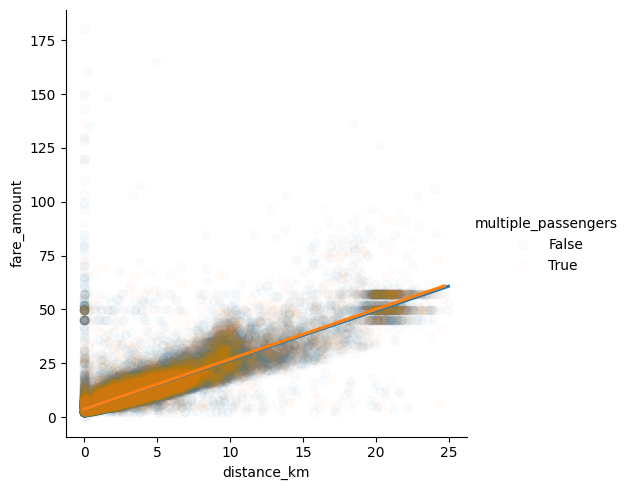

In [485]:
sns.lmplot(data=taxi_pass_red.loc[taxi_pass_red['distance_km'] <= 25], x='distance_km', y='fare_amount', hue='multiple_passengers', scatter_kws={'alpha':0.02})

### Fare vs Time

#### Fare vs Pickup Hour

Text(0.5, 1.0, 'Fare vs Pickup Hour')

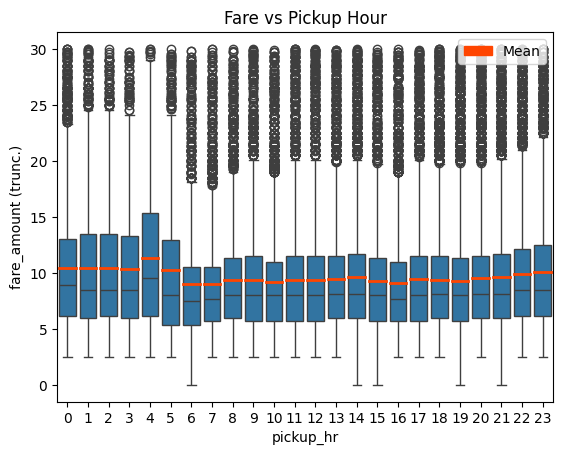

In [486]:
fare_hr_box = sns.boxplot(data=taxi.loc[taxi['fare_amount'] <= 30], x='pickup_hr', y='fare_amount', showmeans=True, meanline=True, meanprops={'linestyle':'-', 'linewidth':2, 'color':'orangered'})
fare_hr_box.set_ylabel(f'{fare_hr_box.get_ylabel()} (trunc.)')
plt.legend(handles=[mpatches.Patch(color='orangered', label='Mean')], loc='upper right')
plt.title('Fare vs Pickup Hour')

#### Fare vs Pickup Day of Week

Text(0.5, 1.0, 'Fare vs Pickup Day of Week')

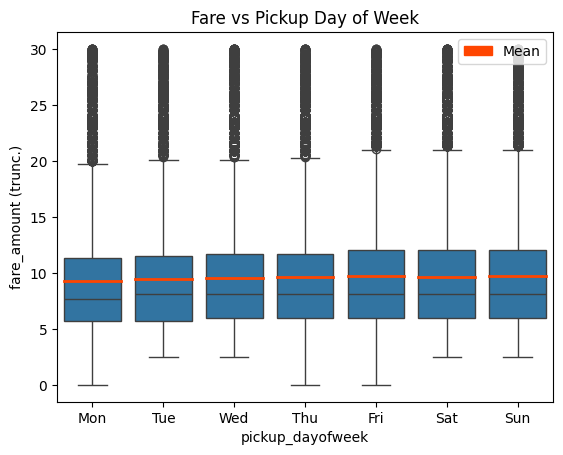

In [487]:
fare_dayofweek_box = sns.boxplot(data=taxi.loc[taxi['fare_amount'] <= 30], x='pickup_dayofweek', y='fare_amount', order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], showmeans=True, meanline=True, meanprops={'linestyle':'-', 'linewidth':2, 'color':'orangered'})
fare_dayofweek_box.set_ylabel(f'{fare_dayofweek_box.get_ylabel()} (trunc.)')
plt.legend(handles=[mpatches.Patch(color='orangered', label='Mean')], loc='upper right')
plt.title('Fare vs Pickup Day of Week')

#### Fare vs Pickup Month

Text(0.5, 1.0, 'Fare vs Pickup Month')

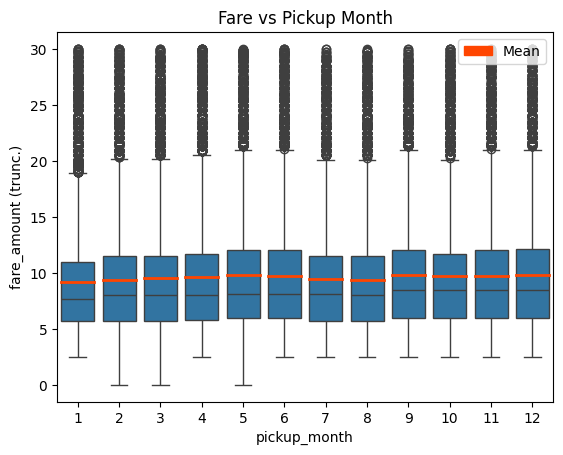

In [488]:
fare_month_box = sns.boxplot(data=taxi.loc[taxi['fare_amount'] <= 30], x='pickup_month', y='fare_amount', showmeans=True, meanline=True, meanprops={'linestyle':'-', 'linewidth':2, 'color':'orangered'})
fare_month_box.set_ylabel(f'{fare_month_box.get_ylabel()} (trunc.)')
plt.legend(handles=[mpatches.Patch(color='orangered', label='Mean')], loc='upper right')
plt.title('Fare vs Pickup Month')

#### Fare vs Pickup Year

Text(0.5, 1.0, 'Fare vs Pickup Year')

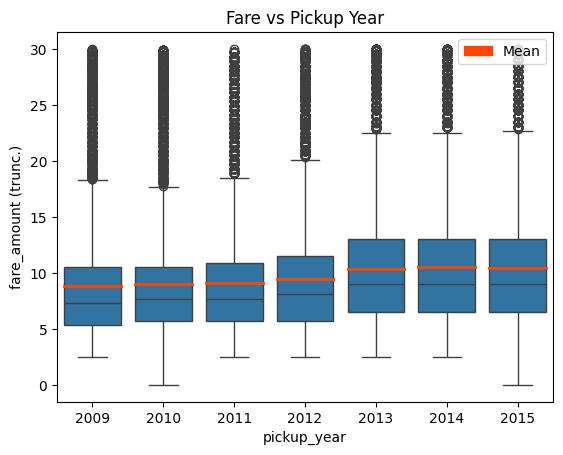

In [489]:
fare_year_box = sns.boxplot(data=taxi.loc[taxi['fare_amount'] <= 30], x='pickup_year', y='fare_amount', showmeans=True, meanline=True, meanprops={'linestyle':'-', 'linewidth':2, 'color':'orangered'})
fare_year_box.set_ylabel(f'{fare_year_box.get_ylabel()} (trunc.)')
plt.legend(handles=[mpatches.Patch(color='orangered', label='Mean')], loc='upper right')
plt.title('Fare vs Pickup Year')

#### Fare vs Pickup Day of Week and Hour

<Axes: xlabel='pickup_dayofweek', ylabel='pickup_hr'>

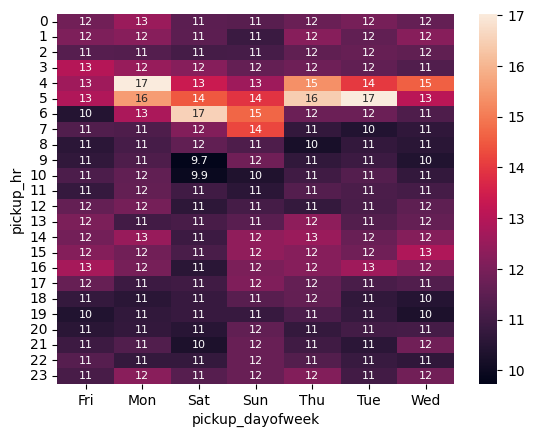

In [490]:
fare_dayofweek_hr = taxi.groupby(['pickup_dayofweek', 'pickup_hr'])['fare_amount'].mean().reset_index()
fare_dayofweek_hr = fare_dayofweek_hr.pivot(index='pickup_hr', columns='pickup_dayofweek', values='fare_amount')

sns.heatmap(data=fare_dayofweek_hr, annot=True, annot_kws={'size':8})

### Location

<Axes: xlabel='pickup_longitude', ylabel='pickup_latitude'>

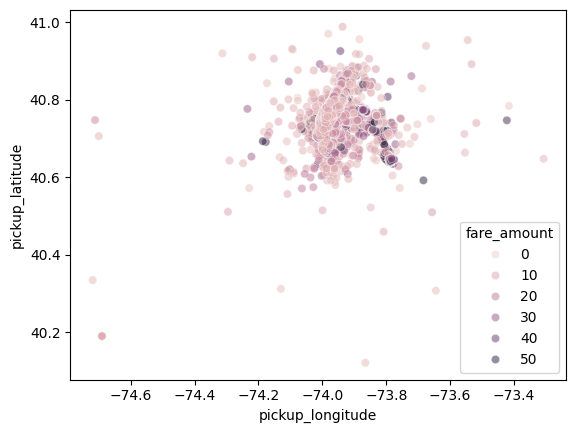

In [491]:
sns.scatterplot(data=taxi.loc[taxi['fare_amount'] <= 50], x='pickup_longitude', y='pickup_latitude', hue='fare_amount', alpha=0.5)

<Axes: xlabel='dropoff_longitude', ylabel='dropoff_latitude'>

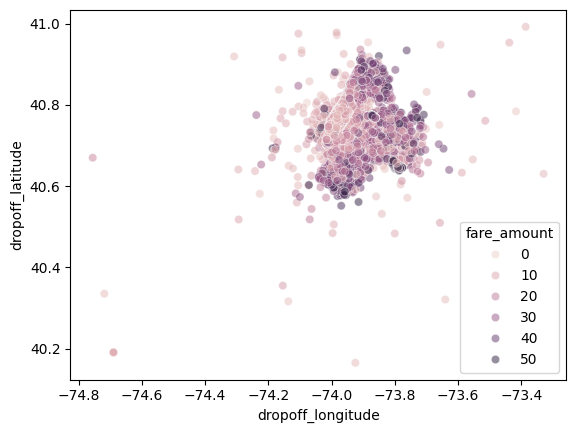

In [492]:
sns.scatterplot(data=taxi.loc[taxi['fare_amount'] <= 50], x='dropoff_longitude', y='dropoff_latitude', hue='fare_amount', alpha=0.5)

Text(0.5, 1.0, 'Dropoff Location Clusters')

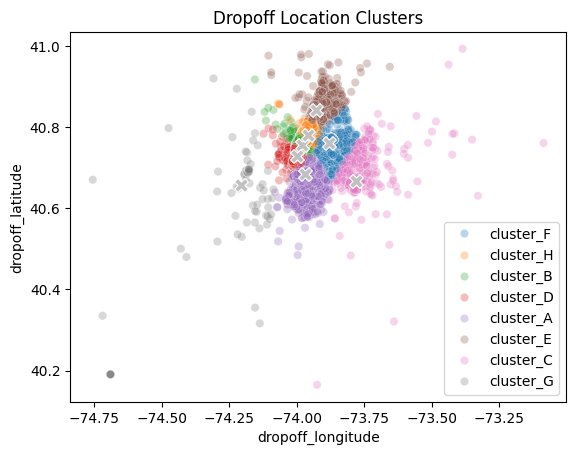

In [493]:
dropoff_locs = taxi[['dropoff_longitude', 'dropoff_latitude']]
# scaler = StandardScaler()
# scaled_dropoff_locs = scaler.fit_transform(dropoff_locs)

kmeans = KMeans(n_clusters=8, n_init=10)
kmeans.fit(dropoff_locs)

clust_name_dict = {i:f'cluster_{c}' for i,c in enumerate(ascii_uppercase)}
kmeans_clusters = pd.Series(kmeans.labels_).replace(clust_name_dict)
kmeans_centroids = pd.DataFrame(kmeans.cluster_centers_).rename(columns={0:'dropoff_longitude', 1:'dropoff_latitude'}, index=clust_name_dict)

sns.scatterplot(data=taxi, x='dropoff_longitude', y='dropoff_latitude', hue=kmeans_clusters, alpha=0.3)
sns.scatterplot(data=kmeans_centroids, x='dropoff_longitude', y='dropoff_latitude', s=100, c='silver', marker='X')
plt.title('Dropoff Location Clusters')

In [494]:
kmeans_cluster_fares = pd.DataFrame()
kmeans_cluster_fares['count'] = taxi.groupby(kmeans_clusters)['key'].count()
kmeans_cluster_fares['mean'] = taxi.groupby(kmeans_clusters)['fare_amount'].mean()
kmeans_cluster_fares['mean_diff'] = kmeans_cluster_fares['mean'] - taxi['fare_amount'].mean()
kmeans_cluster_fares['summed_diff'] = kmeans_cluster_fares['count'] * abs(kmeans_cluster_fares['mean_diff'])
print(kmeans_cluster_fares['summed_diff'].sum()/len(taxi))
kmeans_cluster_fares.head(100)

# ax = sns.barplot(kmeans_cluster_fares)
# ax.bar_label(ax.containers[0], fontsize=6)

2.687891158467081


,count,mean,mean_diff,summed_diff
cluster_A,4516,18.622243,7.284233,32895.597888
cluster_B,39519,9.692062,-1.645948,65046.228022
cluster_C,1193,40.754920,29.416911,35094.374347
cluster_D,25888,10.079980,-1.258030,32567.876874
cluster_E,1670,21.238413,9.900403,16533.673687
cluster_F,3070,23.441889,12.103879,37158.910012
cluster_G,188,60.804628,49.466618,9299.724164
cluster_H,21417,9.779987,-1.558023,33368.175201


In [495]:
# optics_model = OPTICS(min_cluster_size=0.01)
# optics_model.fit(taxi[['dropoff_longitude', 'dropoff_latitude']])

# optics_clusters = pd.Series(optics_model.labels_).replace(clust_name_dict)
# optics_clusters.head(20)

# sns.scatterplot(data=taxi, x='dropoff_longitude', y='dropoff_latitude', hue=optics_clusters, alpha=0.3)

In [496]:
# optics_cluster_fares = pd.DataFrame()
# optics_cluster_fares['count'] = taxi.groupby(optics_clusters)['key'].count()
# optics_cluster_fares['mean'] = taxi.groupby(optics_clusters)['fare_amount'].mean()
# optics_cluster_fares['mean_diff'] = optics_cluster_fares['mean'] - taxi['fare_amount'].mean()
# optics_cluster_fares['summed_diff'] = optics_cluster_fares['count'] * abs(optics_cluster_fares['mean_diff'])
# print(optics_cluster_fares['summed_diff'].sum()/len(taxi))
# optics_cluster_fares.head(100)

## Data Selection

In [497]:
y = taxi['fare_amount']

numerical_features = ['distance_km']
categorical_features = ['pickup_year', 'pickup_hr', 'pickup_dayofweek', 'pickup_loc', 'dropoff_loc', 'distance_loc']

features_list = numerical_features + categorical_features

X_incl_cat = taxi[features_list]
X = pd.get_dummies(X_incl_cat, columns=categorical_features)



## Modelling

In [498]:
test_size_vals = [0.2, 0.1, 0.4]
results_dict = {}

repeats = 10
aggr_RMSE_list = [0 for _ in range(repeats)]

model = LinearRegression()
for test_size_val in test_size_vals:
    for repeat in range(repeats):
        train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=test_size_val, random_state=repeat)
        model.fit(train_X, train_y)
        pred_y = model.predict(val_X)
        aggr_RMSE_list[repeat] = mean_squared_error(val_y, pred_y, squared=False)
    # print(*aggr_RMSE_list)
    aggr_RMSE = (sum(aggr_RMSE_list)/len(aggr_RMSE_list))
    results_dict[test_size_val] = round(aggr_RMSE, 4)

results = pd.Series(results_dict)
print(results)
print(f"Mean RMSE: {results.mean():.4f}")

0.2    4.5927
0.1    4.6475
0.4    4.6232
dtype: float64
Mean RMSE: 4.6211


In [499]:
# train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=1)

# linreg = LinearRegression()
# linreg.fit(train_X, train_y)

# pred_y = linreg.predict(val_X)
# RMSE = mean_squared_error(val_y, pred_y, squared=False)

# print(f'Linear Regression model with coefficients: {linreg.coef_.round(4)}, and intercept: {round(linreg.intercept_, 4)}')
# print(f'RMSE: {round(RMSE, 4)}')